In [13]:
import os
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_auc_score,
    r2_score, mean_absolute_error
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, VotingClassifier
)

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

plt.style.use("ggplot")
sns.set_context("notebook")

RANDOM_STATE = 42
YEARS = [2014, 2015, 2016, 2017, 2018]
DATA_DIR = "."  # adapte si besoin


In [14]:
def read_csv_robust(path):
    """
    Essaye ',' et ';' et garde celui qui donne le plus de colonnes.
    """
    best_df = None
    best_sep = None
    best_ncols = -1

    for sep in [",", ";"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] > best_ncols:
                best_df = df
                best_sep = sep
                best_ncols = df.shape[1]
        except Exception:
            continue

    if best_df is None:
        raise ValueError(f"Impossible de lire le fichier: {path}")

    return best_df, best_sep


def load_yearly_csvs(years, data_dir="."):
    dfs = []
    for y in years:
        path = os.path.join(data_dir, f"{y}_Financial_Data.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Fichier manquant: {path}")

        df, sep = read_csv_robust(path)
        df["Year"] = y
        print(f"Loaded {os.path.basename(path)} (sep='{sep}') -> shape {df.shape}")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True)

    # drop colonnes index parasites courantes
    for c in ["Unnamed: 0", "Unnamed: 0.1"]:
        if c in data.columns:
            data = data.drop(columns=[c])

    print("Final loaded shape:", data.shape)
    return data


def clean_colname(c):
    if not isinstance(c, str):
        return c
    c = c.replace("\ufeff", "")   # BOM éventuel
    c = c.replace('"', "").strip()
    c = " ".join(c.split())       # espaces multiples -> 1
    return c


In [15]:
data = load_yearly_csvs(YEARS, DATA_DIR)
data.columns = [clean_colname(c) for c in data.columns]

# Drop colonnes "fantômes" si jamais
ghost_cols = [c for c in data.columns if isinstance(c, str) and c.strip().startswith(";")]
if ghost_cols:
    print(f"Dropping {len(ghost_cols)} ghost col(s). Example:", ghost_cols[0])
    data = data.drop(columns=ghost_cols)

print("After cleanup:", data.shape)
data.head(2)


Loaded 2014_Financial_Data.csv (sep=';') -> shape (3808, 227)
Loaded 2015_Financial_Data.csv (sep=';') -> shape (4120, 226)
Loaded 2016_Financial_Data.csv (sep=',') -> shape (4797, 226)
Loaded 2017_Financial_Data.csv (sep=',') -> shape (4960, 226)
Loaded 2018_Financial_Data.csv (sep=',') -> shape (4392, 226)
Final loaded shape: (22077, 231)
After cleanup: (22077, 231)


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,Year,"Property, Plant & Equipment Net",2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
0,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,1.449400e+10,...,Consumer Defensive,-9.323276,0.0,NaN,2014,NaN,NaN,NaN,NaN,NaN
1,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,...,Consumer Defensive,-25.512193,0.0,NaN,2014,NaN,NaN,NaN,NaN,NaN


In [16]:
# Colonnes "PRICE VAR"
price_var_cols = [c for c in data.columns if isinstance(c, str) and "PRICE VAR" in c.upper()]
if not price_var_cols:
    raise ValueError("Aucune colonne 'PRICE VAR' trouvée.")

def target_col_for_year(y: int) -> str:
    return f"{y+1} PRICE VAR [%]"

data2 = data.copy()
data2["Target_Price_Var"] = np.nan

for y in sorted(data2["Year"].unique()):
    col = target_col_for_year(int(y))
    if col in data2.columns:
        mask = data2["Year"] == y
        data2.loc[mask, "Target_Price_Var"] = pd.to_numeric(data2.loc[mask, col], errors="coerce")

print("Target null rate:", data2["Target_Price_Var"].isna().mean())

# anti-leakage: drop toutes les colonnes PRICE VAR originales
data2 = data2.drop(columns=price_var_cols)

# parfois "Class" existe : on le drop
if "Class" in data2.columns:
    data2 = data2.drop(columns=["Class"])

data2[["Year", "Target_Price_Var"]].head()


Target null rate: 0.0


,Year,Target_Price_Var
0,2014,0.0
1,2014,0.0
2,2014,1.0
3,2014,1.0
4,2014,1.0


In [17]:
data_clean = data2.dropna(subset=["Target_Price_Var"]).copy()

# clip target
data_clean["Target_Price_Var"] = data_clean["Target_Price_Var"].clip(lower=-99, upper=500)

# drop colonnes trop manquantes (>40% NA)
threshold = 0.40
min_non_na = int(len(data_clean) * (1 - threshold))
data_clean = data_clean.dropna(axis=1, thresh=min_non_na)

# target binaire
data_clean["Target_Buy"] = (data_clean["Target_Price_Var"] > 0).astype(int)

# defragment (perf warning)
data_clean = data_clean.copy()

print("Shape clean:", data_clean.shape)
print("Buy rate:", data_clean["Target_Buy"].mean().round(4))


Shape clean: (22077, 218)
Buy rate: 0.5499


In [18]:
data_clean = data2.dropna(subset=["Target_Price_Var"]).copy()

# clip target
data_clean["Target_Price_Var"] = data_clean["Target_Price_Var"].clip(lower=-99, upper=500)

# drop colonnes trop manquantes (>40% NA)
threshold = 0.40
min_non_na = int(len(data_clean) * (1 - threshold))
data_clean = data_clean.dropna(axis=1, thresh=min_non_na)

# target binaire
data_clean["Target_Buy"] = (data_clean["Target_Price_Var"] > 0).astype(int)

# defragment (perf warning)
data_clean = data_clean.copy()

print("Shape clean:", data_clean.shape)
print("Buy rate:", data_clean["Target_Buy"].mean().round(4))


Shape clean: (22077, 218)
Buy rate: 0.5499


In [19]:
train_df = data_clean[data_clean["Year"].isin([2014, 2015, 2016, 2017])].copy()
test_df  = data_clean[data_clean["Year"] == 2018].copy()

y_train = train_df["Target_Buy"].values
y_test  = test_df["Target_Buy"].values

print("Train shape:", train_df.shape, "| Test shape:", test_df.shape)
print("Train buy rate:", y_train.mean().round(4), "| Test buy rate:", y_test.mean().round(4))


Train shape: (17685, 218) | Test shape: (4392, 218)
Train buy rate: 0.5146 | Test buy rate: 0.6919


In [20]:
num_cols = [c for c in train_df.select_dtypes(include=np.number).columns
            if c not in ["Year", "Target_Price_Var", "Target_Buy"]]

q_low = train_df[num_cols].quantile(0.01)
q_high = train_df[num_cols].quantile(0.99)

train_df[num_cols] = train_df[num_cols].clip(q_low, q_high, axis=1)
test_df[num_cols]  = test_df[num_cols].clip(q_low, q_high, axis=1)

print("Winsorisation features: done (train-bounds-only).")


Winsorisation features: done (train-bounds-only).


In [21]:
raw_feature_cols = train_df.select_dtypes(include=np.number).columns.tolist()
raw_feature_cols = [c for c in raw_feature_cols if c not in ["Year", "Target_Price_Var", "Target_Buy"]]

X_train_raw = train_df[raw_feature_cols].copy()
X_test_raw  = test_df[raw_feature_cols].copy()

print("RAW features:", len(raw_feature_cols))


RAW features: 213


In [22]:
def add_financial_ratios(df: pd.DataFrame):
    out = df.copy()

    # ---- equity ----
    possible_equity_cols = [
        "Total shareholders equity",
        "Shareholders Equity",
        "Total Shareholders Equity",
        "Total stockholders' equity",
        "Total Stockholders Equity",
    ]
    equity_col = next((c for c in possible_equity_cols if c in out.columns), None)

    if equity_col is None:
        assets_col = "Total assets" if "Total assets" in out.columns else ("Total Assets" if "Total Assets" in out.columns else None)
        liab_col = "Total liabilities" if "Total liabilities" in out.columns else ("Total Liabilities" if "Total Liabilities" in out.columns else None)

        out["Calc_Equity"] = (
            pd.to_numeric(out.get(assets_col, np.nan), errors="coerce")
            - pd.to_numeric(out.get(liab_col, np.nan), errors="coerce")
        )
        equity_col = "Calc_Equity"

    # ---- debt ----
    possible_debt_cols = [
        "Total Debt", "Total debt",
        "Long-term debt", "Long-term Debt",
        "Short-term debt", "Short-term Debt",
        "Net Debt", "Net debt"
    ]
    debt_col = next((c for c in possible_debt_cols if c in out.columns), None)

    # ---- series ----
    eps = 1e-6
    net_income = pd.to_numeric(out.get("Net Income", np.nan), errors="coerce")
    revenue    = pd.to_numeric(out.get("Revenue", np.nan), errors="coerce")
    equity     = pd.to_numeric(out.get(equity_col, np.nan), errors="coerce")
    debt       = pd.to_numeric(out.get(debt_col, np.nan), errors="coerce") if debt_col else np.nan

    # ---- ratios ----
    out["ROE_calc"] = net_income / (equity + eps)
    out["Net_Margin_calc"] = net_income / (revenue + eps)
    out["Debt_to_Equity_calc"] = debt / (equity + eps)

    meta = {"equity_col": equity_col, "debt_col": debt_col}
    return out, meta


train_eng, meta_train = add_financial_ratios(train_df)
test_eng,  meta_test  = add_financial_ratios(test_df)

desired_features = [
    "ROE_calc", "Net_Margin_calc", "Debt_to_Equity_calc",
    "EPS", "EBITDA", "Operating Cash Flow", "Market Cap"
]
engineered_cols = [c for c in desired_features if c in train_eng.columns and c in test_eng.columns]

X_train_eng = train_eng[engineered_cols].copy()
X_test_eng  = test_eng[engineered_cols].copy()

print("ENGINEERED features:", engineered_cols)
print("Debt col used (train):", meta_train["debt_col"], "| Equity col used (train):", meta_train["equity_col"])
print("Debt col used (test) :", meta_test["debt_col"],  "| Equity col used (test) :", meta_test["equity_col"])
print("Debt_to_Equity_calc NA train:", train_eng["Debt_to_Equity_calc"].isna().mean())
print("Debt_to_Equity_calc NA test :", test_eng["Debt_to_Equity_calc"].isna().mean())


ENGINEERED features: ['ROE_calc', 'Net_Margin_calc', 'Debt_to_Equity_calc', 'EPS', 'EBITDA', 'Operating Cash Flow', 'Market Cap']
Debt col used (train): Total debt | Equity col used (train): Total shareholders equity
Debt col used (test) : Total debt | Equity col used (test) : Total shareholders equity
Debt_to_Equity_calc NA train: 0.0914334181509754
Debt_to_Equity_calc NA test : 0.03825136612021858


--- 🔒 SEED FIXÉE À 42 ---
--- 🚀 DÉMARRAGE DEEP LEARNING : MODE CALIBRÉ ---
--- Entraînement du réseau de neurones en cours... ---
--- Entraînement terminé ---


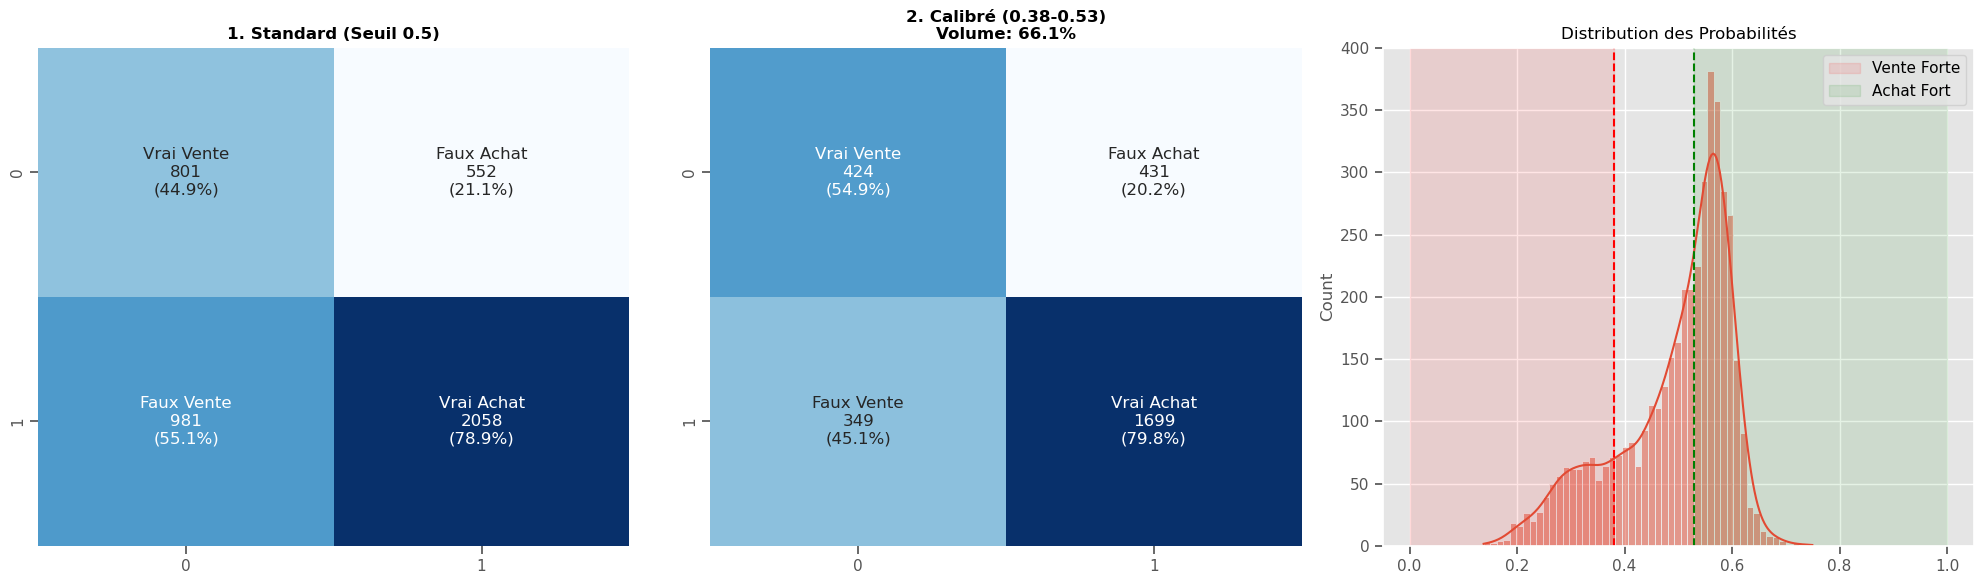

✅ Modèle Deep Learning terminé. Résultat stocké dans la variable 'nn_res'.


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import QuantileTransformer

# 1. VERROUILLAGE DU HASARD (SEED)
# --------------------------------
SEED_VALUE = 42
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(f"--- 🔒 SEED FIXÉE À {SEED_VALUE} ---")
print("--- 🚀 DÉMARRAGE DEEP LEARNING : MODE CALIBRÉ ---")

# 2. PRÉPARATION DES DONNÉES (Spécifique au NN)
# ---------------------------------------------
# On repart de X_train_eng et X_test_eng créés précédemment
imputer_safety = SimpleImputer(strategy='median')
X_train_safe = imputer_safety.fit_transform(X_train_eng)
X_test_safe = imputer_safety.transform(X_test_eng)

# Transformation Quantile pour normaliser la distribution (très efficace pour les NN)
scaler_nn = QuantileTransformer(output_distribution='normal', n_quantiles=1000, random_state=SEED_VALUE)
X_train_nn = scaler_nn.fit_transform(X_train_safe)
X_test_nn = scaler_nn.transform(X_test_safe)

# Poids manuel (optionnel, ici on favorise légèrement la classe 0 si déséquilibrée)
manual_weights = {0: 1.5, 1: 1.0} 

# 3. ARCHITECTURE DU MODÈLE
# -------------------------
def build_robust_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128), BatchNormalization(), LeakyReLU(negative_slope=0.1), Dropout(0.4),
        Dense(64), BatchNormalization(), LeakyReLU(negative_slope=0.1), Dropout(0.3),
        Dense(32), LeakyReLU(negative_slope=0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

model_nn = build_robust_model(X_train_nn.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("--- Entraînement du réseau de neurones en cours... ---")
history = model_nn.fit(
    X_train_nn, y_train,  # Utilisation de y_train du script précédent
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=manual_weights,
    verbose=0
)
print("--- Entraînement terminé ---")

# Prédictions (Probabilités brutes)
preds_probs = model_nn.predict(X_test_nn, verbose=0)

# 4. ANALYSE & CALIBRAGE (Seuils 0.38 / 0.53)
# -------------------------------------------
# Approche Standard (> 0.5)
preds_std = (preds_probs > 0.5).astype(int)

# Approche Calibrée (Zone neutre entre 0.38 et 0.53)
SEUIL_BAS = 0.38
SEUIL_HAUT = 0.53

mask_active = (preds_probs < SEUIL_BAS) | (preds_probs > SEUIL_HAUT)
mask_active = mask_active.flatten()

# On filtre les données de test pour ne garder que celles où le modèle est "sûr"
# Attention : y_test correspond au y_test du script précédent
y_test_active = y_test[mask_active]
probs_active = preds_probs[mask_active]
preds_active = (probs_active > SEUIL_HAUT).astype(int)

taux_activite = len(preds_active) / len(preds_probs)

# 5. VISUALISATION
# ----------------
def plot_results(y_true, y_pred, title, ax_cm):
    cm = confusion_matrix(y_true, y_pred)
    # Gestion des cas où une classe est vide pour éviter division par zéro
    sum_pred_vente = max(cm[0,0] + cm[1,0], 1)
    sum_pred_achat = max(cm[0,1] + cm[1,1], 1)
    
    p_vrai_vente = cm[0,0] / sum_pred_vente
    p_faux_vente = cm[1,0] / sum_pred_vente
    p_faux_achat = cm[0,1] / sum_pred_achat
    p_vrai_achat = cm[1,1] / sum_pred_achat
    
    labels = np.array([
        [f"Vrai Vente\n{cm[0,0]}\n({p_vrai_vente:.1%})", f"Faux Achat\n{cm[0,1]}\n({p_faux_achat:.1%})"],
        [f"Faux Vente\n{cm[1,0]}\n({p_faux_vente:.1%})", f"Vrai Achat\n{cm[1,1]}\n({p_vrai_achat:.1%})"]
    ])
    cm_norm = np.array([[p_vrai_vente, p_faux_achat], [p_faux_vente, p_vrai_achat]])
    
    sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues', ax=ax_cm, cbar=False)
    ax_cm.set_title(title, fontsize=12, weight='bold')

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1 : Standard
plot_results(y_test, preds_std, "1. Standard (Seuil 0.5)", axes[0])

# Plot 2 : Calibré
if len(y_test_active) > 0:
    plot_results(y_test_active, preds_active, f"2. Calibré ({SEUIL_BAS}-{SEUIL_HAUT})\nVolume: {taux_activite:.1%}", axes[1])
else:
    axes[1].text(0.5, 0.5, "Aucun trade pris", ha='center')

# Plot 3 : Histogramme
sns.histplot(preds_probs, bins=50, kde=True, ax=axes[2], color='gray')
axes[2].axvspan(0, SEUIL_BAS, color='red', alpha=0.1, label='Vente Forte')
axes[2].axvspan(SEUIL_HAUT, 1, color='green', alpha=0.1, label='Achat Fort')
axes[2].axvline(SEUIL_BAS, color='red', linestyle='--')
axes[2].axvline(SEUIL_HAUT, color='green', linestyle='--')
axes[2].set_title("Distribution des Probabilités")
axes[2].legend()

plt.tight_layout()
plt.show()

# 6. AJOUT AUX RÉSULTATS GLOBAUX (Pour le tableau final)
# ------------------------------------------------------
# On ajoute le résultat "Standard" du NN au tableau comparatif
acc_nn = accuracy_score(y_test, preds_std)
bacc_nn = balanced_accuracy_score(y_test, preds_std)
# Calcul AUC (nécessite probas 1D)
try:
    auc_nn = roc_auc_score(y_test, preds_probs)
except:
    auc_nn = 0

nn_res = {
    "model": "Keras-MLP-Standard",
    "acc": acc_nn,
    "bacc": bacc_nn,
    "auc": auc_nn
}

print("✅ Modèle Deep Learning terminé. Résultat stocké dans la variable 'nn_res'.")


In [24]:
def eval_classifier(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    bacc = balanced_accuracy_score(y_test, preds)

    print(f"\n=== {name} ===")
    print(f"Accuracy:          {acc:.4f}")
    print(f"Balanced Accuracy: {bacc:.4f}")

    auc = None
    if proba is not None:
        auc = roc_auc_score(y_test, proba)
        print(f"ROC-AUC:           {auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, preds, digits=4))

    return {
        "model": name,
        "acc": acc,
        "bacc": bacc,
        "auc": auc
    }


In [25]:
y_train_reg = train_df["Target_Price_Var"].values
y_test_reg  = test_df["Target_Price_Var"].values

reg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression()),
])

reg_pipeline.fit(X_train_raw, y_train_reg)
preds_reg = reg_pipeline.predict(X_test_raw)

print("Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test_reg, preds_reg):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, preds_reg):.2f}%")


Linear Regression Results:
R2 Score: -0.0613
Mean Absolute Error (MAE): 37.07%


In [26]:
raw_models = {
    "RAW-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "RAW-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=300, class_weight="balanced",
            random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "RAW-GradBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "RAW-HistGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

results = []
for name, model in raw_models.items():
    results.append(eval_classifier(model, X_train_raw, y_train, X_test_raw, y_test, name=name))

results_df = pd.DataFrame(results)
results_df.sort_values(by="auc", ascending=False)



=== RAW-LogReg ===
Accuracy:          0.6651
Balanced Accuracy: 0.6134
ROC-AUC:           0.6593

Classification report:
              precision    recall  f1-score   support

           0     0.4583    0.4789    0.4684      1353
           1     0.7633    0.7479    0.7555      3039

    accuracy                         0.6651      4392
   macro avg     0.6108    0.6134    0.6120      4392
weighted avg     0.6693    0.6651    0.6671      4392


=== RAW-RF ===
Accuracy:          0.6551
Balanced Accuracy: 0.6296
ROC-AUC:           0.6892

Classification report:
              precision    recall  f1-score   support

           0     0.4520    0.5632    0.5015      1353
           1     0.7816    0.6960    0.7363      3039

    accuracy                         0.6551      4392
   macro avg     0.6168    0.6296    0.6189      4392
weighted avg     0.6800    0.6551    0.6640      4392


=== RAW-GradBoost ===
Accuracy:          0.6751
Balanced Accuracy: 0.6299
ROC-AUC:           0.6876

Clas

c:\Users\grego\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\grego\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\grego\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\grego\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\grego\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e


=== RAW-HistGB ===
Accuracy:          0.6494
Balanced Accuracy: 0.6230
ROC-AUC:           0.6776

Classification report:
              precision    recall  f1-score   support

           0     0.4446    0.5543    0.4934      1353
           1     0.7771    0.6917    0.7319      3039

    accuracy                         0.6494      4392
   macro avg     0.6108    0.6230    0.6127      4392
weighted avg     0.6746    0.6494    0.6584      4392



,model,acc,bacc,auc
1,RAW-RF,0.655055,0.629573,0.689172
2,RAW-GradBoost,0.675091,0.629905,0.687623
3,RAW-HistGB,0.649362,0.622999,0.677568
0,RAW-LogReg,0.665073,0.613440,0.659308


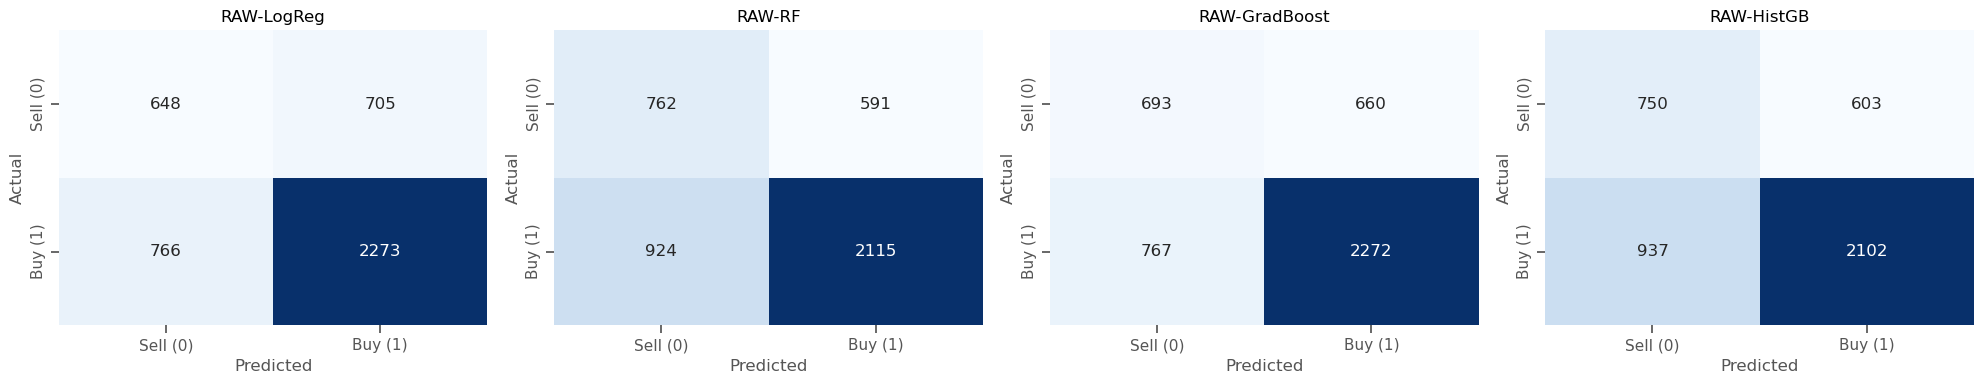

In [27]:
fig, axes = plt.subplots(1, len(raw_models), figsize=(5 * len(raw_models), 4))
if len(raw_models) == 1:
    axes = [axes]

for ax, (name, model) in zip(axes, raw_models.items()):
    model.fit(X_train_raw, y_train)
    preds = model.predict(X_test_raw)
    cm = confusion_matrix(y_test, preds)

    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
        xticklabels=["Sell (0)", "Buy (1)"],
        yticklabels=["Sell (0)", "Buy (1)"]
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


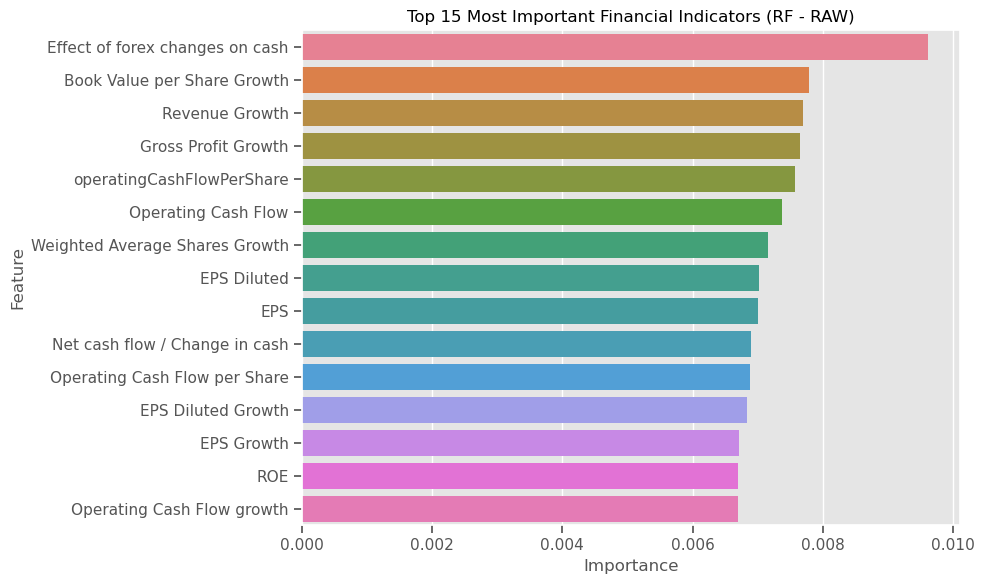

,Feature,Importance
70,Effect of forex changes on cash,0.009618
209,Book Value per Share Growth,0.007780
1,Revenue Growth,0.007692
184,Gross Profit Growth,0.007652
117,operatingCashFlowPerShare,0.007564
61,Operating Cash Flow,0.007368
190,Weighted Average Shares Growth,0.007161
17,EPS Diluted,0.007023
16,EPS,0.007006
71,Net cash flow / Change in cash,0.006892


In [28]:
rf_for_importance = raw_models["RAW-RF"]
rf_for_importance.fit(X_train_raw, y_train)

rf_step = rf_for_importance.named_steps["clf"]
importances = rf_step.feature_importances_

df_imp = pd.DataFrame({
    "Feature": raw_feature_cols,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x="Importance", y="Feature", hue="Feature", dodge=False, legend=False)
plt.title("Top 15 Most Important Financial Indicators (RF - RAW)")
plt.tight_layout()
plt.show()

df_imp


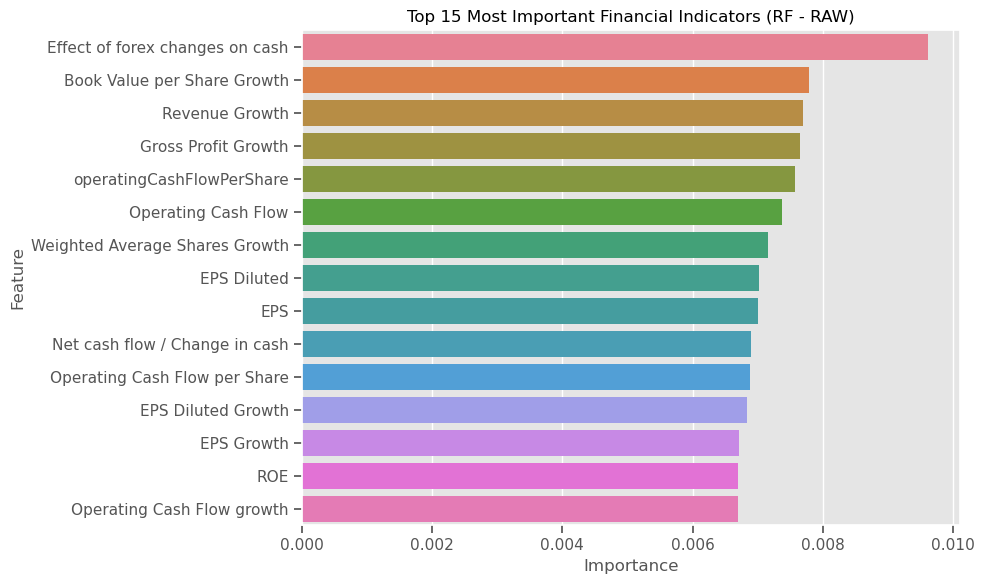

,Feature,Importance
70,Effect of forex changes on cash,0.009618
209,Book Value per Share Growth,0.007780
1,Revenue Growth,0.007692
184,Gross Profit Growth,0.007652
117,operatingCashFlowPerShare,0.007564
61,Operating Cash Flow,0.007368
190,Weighted Average Shares Growth,0.007161
17,EPS Diluted,0.007023
16,EPS,0.007006
71,Net cash flow / Change in cash,0.006892


In [29]:
rf_for_importance = raw_models["RAW-RF"]
rf_for_importance.fit(X_train_raw, y_train)

rf_step = rf_for_importance.named_steps["clf"]
importances = rf_step.feature_importances_

df_imp = pd.DataFrame({
    "Feature": raw_feature_cols,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x="Importance", y="Feature", hue="Feature", dodge=False, legend=False)
plt.title("Top 15 Most Important Financial Indicators (RF - RAW)")
plt.tight_layout()
plt.show()

df_imp


In [30]:
pca_models = {
    "PCA95-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "PCA95-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
        ("clf", RandomForestClassifier(
            n_estimators=300, class_weight="balanced",
            random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "PCA95-GradBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

pca_results = []
for name, model in pca_models.items():
    pca_results.append(eval_classifier(model, X_train_raw, y_train, X_test_raw, y_test, name=name))

pca_results_df = pd.DataFrame(pca_results)
pca_results_df.sort_values(by="auc", ascending=False)



=== PCA95-LogReg ===
Accuracy:          0.6628
Balanced Accuracy: 0.6097
ROC-AUC:           0.6659

Classification report:
              precision    recall  f1-score   support

           0     0.4544    0.4715    0.4628      1353
           1     0.7607    0.7479    0.7543      3039

    accuracy                         0.6628      4392
   macro avg     0.6076    0.6097    0.6085      4392
weighted avg     0.6664    0.6628    0.6645      4392


=== PCA95-RF ===
Accuracy:          0.6416
Balanced Accuracy: 0.6121
ROC-AUC:           0.6656

Classification report:
              precision    recall  f1-score   support

           0     0.4338    0.5351    0.4792      1353
           1     0.7690    0.6890    0.7268      3039

    accuracy                         0.6416      4392
   macro avg     0.6014    0.6121    0.6030      4392
weighted avg     0.6657    0.6416    0.6505      4392


=== PCA95-GradBoost ===
Accuracy:          0.6781
Balanced Accuracy: 0.6204
ROC-AUC:           0.6783

,model,acc,bacc,auc
2,PCA95-GradBoost,0.678051,0.620357,0.678271
0,PCA95-LogReg,0.662796,0.609744,0.665908
1,PCA95-RF,0.641621,0.612075,0.665605


In [31]:
eng_models = {
    "ENG-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "ENG-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=300, class_weight="balanced",
            random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "ENG-GradBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "ENG-HistGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

eng_results = []
for name, model in eng_models.items():
    eng_results.append(eval_classifier(model, X_train_eng, y_train, X_test_eng, y_test, name=name))

eng_results_df = pd.DataFrame(eng_results)
eng_results_df.sort_values(by="auc", ascending=False)



=== ENG-LogReg ===
Accuracy:          0.6719
Balanced Accuracy: 0.6452
ROC-AUC:           0.6800

Classification report:
              precision    recall  f1-score   support

           0     0.4733    0.5758    0.5195      1353
           1     0.7910    0.7147    0.7509      3039

    accuracy                         0.6719      4392
   macro avg     0.6321    0.6452    0.6352      4392
weighted avg     0.6931    0.6719    0.6796      4392


=== ENG-RF ===
Accuracy:          0.6009
Balanced Accuracy: 0.5644
ROC-AUC:           0.6033

Classification report:
              precision    recall  f1-score   support

           0     0.3802    0.4693    0.4201      1353
           1     0.7362    0.6594    0.6957      3039

    accuracy                         0.6009      4392
   macro avg     0.5582    0.5644    0.5579      4392
weighted avg     0.6266    0.6009    0.6108      4392


=== ENG-GradBoost ===
Accuracy:          0.6842
Balanced Accuracy: 0.6158
ROC-AUC:           0.6682

Clas

,model,acc,bacc,auc
0,ENG-LogReg,0.671903,0.645233,0.680002
3,ENG-HistGB,0.686931,0.621033,0.672125
2,ENG-GradBoost,0.684199,0.615779,0.668152
1,ENG-RF,0.600865,0.564377,0.603253


In [32]:
param_dist = {
    "clf__n_estimators": [100, 200, 300, 500],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__class_weight": ["balanced", "balanced_subsample"]
}

tuning_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

search_classic = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

search_classic.fit(X_train_raw, y_train)

print("Best Parameters found (classic CV):", search_classic.best_params_)
print(f"Best CV Accuracy (classic): {search_classic.best_score_:.4f}")

best_rf_classic = search_classic.best_estimator_
classic_res = eval_classifier(best_rf_classic, X_train_raw, y_train, X_test_raw, y_test, name="TUNED-RF-classicCV")
classic_res


Best Parameters found (classic CV): {'clf__n_estimators': 100, 'clf__min_samples_leaf': 2, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}
Best CV Accuracy (classic): 0.5584

=== TUNED-RF-classicCV ===
Accuracy:          0.6428
Balanced Accuracy: 0.6156
ROC-AUC:           0.6802

Classification report:
              precision    recall  f1-score   support

           0     0.4361    0.5447    0.4844      1353
           1     0.7720    0.6864    0.7267      3039

    accuracy                         0.6428      4392
   macro avg     0.6041    0.6156    0.6055      4392
weighted avg     0.6685    0.6428    0.6521      4392



{'model': 'TUNED-RF-classicCV',
 'acc': 0.64275956284153,
 'bacc': 0.6155627252225138,
 'auc': 0.6802169237702428}

In [33]:
# dataset "train only" trié par année
train_only = train_df.sort_values("Year").copy()
X_tv = train_only[raw_feature_cols].copy()
y_tv = train_only["Target_Buy"].values

tscv = TimeSeriesSplit(n_splits=3)

search_time = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=tscv,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

search_time.fit(X_tv, y_tv)

print("Best Parameters found (TimeSeriesSplit):", search_time.best_params_)
print(f"Best CV ROC-AUC (temporal): {search_time.best_score_:.4f}")

best_rf_time = search_time.best_estimator_
time_res = eval_classifier(best_rf_time, X_train_raw, y_train, X_test_raw, y_test, name="TUNED-RF-TimeSeriesSplit")
time_res


Best Parameters found (TimeSeriesSplit): {'clf__n_estimators': 500, 'clf__min_samples_leaf': 2, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}
Best CV ROC-AUC (temporal): 0.5956

=== TUNED-RF-TimeSeriesSplit ===
Accuracy:          0.6537
Balanced Accuracy: 0.6298
ROC-AUC:           0.6942

Classification report:
              precision    recall  f1-score   support

           0     0.4507    0.5676    0.5025      1353
           1     0.7824    0.6920    0.7344      3039

    accuracy                         0.6537      4392
   macro avg     0.6165    0.6298    0.6184      4392
weighted avg     0.6802    0.6537    0.6630      4392



{'model': 'TUNED-RF-TimeSeriesSplit',
 'acc': 0.6536885245901639,
 'bacc': 0.6298157215620437,
 'auc': 0.6942110289809711}

In [34]:
voting = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE)),
        ("rf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)),
        ("hgb", HistGradientBoostingClassifier(random_state=RANDOM_STATE)),
    ],
    voting="soft"
)

voting_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", voting)
])

voting_res = eval_classifier(voting_pipe, X_train_raw, y_train, X_test_raw, y_test, name="RAW-Voting(soft)")
voting_res



=== RAW-Voting(soft) ===
Accuracy:          0.6703
Balanced Accuracy: 0.6338
ROC-AUC:           0.6974

Classification report:
              precision    recall  f1-score   support

           0     0.4694    0.5388    0.5017      1353
           1     0.7802    0.7289    0.7537      3039

    accuracy                         0.6703      4392
   macro avg     0.6248    0.6338    0.6277      4392
weighted avg     0.6845    0.6703    0.6760      4392



{'model': 'RAW-Voting(soft)',
 'acc': 0.6703096539162113,
 'bacc': 0.6338304188928994,
 'auc': 0.6974490529254211}

In [37]:
all_results = []

# 1. Ajout des modèles classiques déjà calculés
all_results.extend(results)          # RAW baselines
all_results.extend(pca_results)      # PCA
all_results.extend(eng_results)      # ENG
all_results.append(classic_res)      # tuned classic
all_results.append(time_res)         # tuned time series
all_results.append(voting_res)       # voting

# 2. Ajout du Deep Learning avec gestion d'erreur explicite
try:
    # On essaie d'accéder à la variable nn_res
    all_results.append(nn_res)
    print("✅ SUCCÈS : Résultat Deep Learning ajouté au tableau.")
except NameError:
    print("⚠️ ATTENTION : La variable 'nn_res' n'existe pas.")
    print("   -> Avez-vous bien exécuté la cellule 'Deep Learning' juste avant ?")
    print("   -> Vérifiez qu'elle est allée jusqu'au bout (message '✅ Modèle Deep Learning terminé').")

# 3. Création et affichage du tableau final
final_df = pd.DataFrame(all_results)

# Formatage pour l'affichage
if not final_df.empty:
    final_df["auc"] = final_df["auc"].astype(float)
    final_df = final_df.sort_values(by=["auc", "bacc"], ascending=False)

    final_df_display = final_df.copy()
    final_df_display["acc"] = (100 * final_df_display["acc"]).round(2)
    final_df_display["bacc"] = (100 * final_df_display["bacc"]).round(2)
    final_df_display["auc"] = final_df_display["auc"].round(4)

    # Affichage propre dans Jupyter
    from IPython.display import display
    display(final_df_display)
else:
    print("Aucun résultat à afficher.")


✅ SUCCÈS : Résultat Deep Learning ajouté au tableau.


,model,acc,bacc,auc
13,RAW-Voting(soft),67.03,63.38,0.6974
12,TUNED-RF-TimeSeriesSplit,65.37,62.98,0.6942
1,RAW-RF,65.51,62.96,0.6892
2,RAW-GradBoost,67.51,62.99,0.6876
11,TUNED-RF-classicCV,64.28,61.56,0.6802
7,ENG-LogReg,67.19,64.52,0.6800
6,PCA95-GradBoost,67.81,62.04,0.6783
3,RAW-HistGB,64.94,62.30,0.6776
10,ENG-HistGB,68.69,62.10,0.6721
14,Keras-MLP-Standard,65.10,63.46,0.6715
